In [2]:
library("AnnotationDbi")
library("org.Hs.eg.db")
library(RUVSeq)
source("../downstreamAnalysis_RNAseqFunctions.R")

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout



Attaching package: ‘plyr’


The following objects are masked from ‘package:plotly’:

    arrange, mutate, rename, summarise


The following object is masked from ‘package:ShortRead’:

    id


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:XVector’:

    compact


The following object is masked from ‘package:IRanges’:

    desc


The following object is masked from ‘pac

In [3]:
# Read in data
cts = as.matrix(read.csv("../../data/cts_i.csv", sep=',', row.names='gene'))
coldata = read.csv('../../data/coldata_i.csv', sep=',', row.names='Sample_ID')

cts = cts[,-which(colnames(cts) == 'PB17_236_257_A5')]
coldata = coldata[-which(rownames(coldata) == 'PB17_236_257_A5'),]
cts = cts[,-which(colnames(cts) == 'PB600298_A4')]
coldata = coldata[-which(rownames(coldata) == 'PB600298_A4'),]
cts = cts[,-which(colnames(cts) == 'PB43300_A1')]
coldata = coldata[-which(rownames(coldata) == 'PB43300_A1'),]


dim(coldata)
dim(cts)


[1] 42 16

[1] 61114    42

In [4]:
factor_cols = c('sex', 'recur', 'inflammation_status', 'source')
for (col in factor_cols) {
  coldata[,col] = as.factor(coldata[,col])
}
sex = coldata$sex
source = coldata$source
# tissue = coldata$tissue
recur = coldata$recur
inflammation_status = coldata$inflammation_status
tin = coldata$TIN

sample = rownames(coldata)

#round counts to integers
cts <- round(cts);

#check if row names of coldata match colnames of cts
all(rownames(coldata) == colnames(cts))

#adjust for batch and sexBin
design <- as.formula(~ recur)
#create the dds object
dds = DESeqDataSetFromMatrix(countData = cts, colData = coldata, design = design)

vsd = vst(dds)
mat = assay(vsd)
#PCA of raw data
pcaData <- plotPCA(vsd, intgroup=c("recur"), ntop = 500, returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))


[1] TRUE

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [5]:

# #save the plot
# png("results/i/pca_source_raw.png", width=1024, height=512)
# ggplot(pcaData, aes(PC1, PC2, color=source, shape=recur)) +
#     geom_point(size=5) +
#     #geom_text(aes(label=sample),hjust=0, vjust=0) +
#     xlab(paste0("PC1: ",percentVar[1],"% variance")) +
#     ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
#     coord_fixed() +
    
#     theme(text = element_text(size = 24))
# dev.off()

In [6]:
library('GenomicFeatures')
#use the GenomicFeatures package to create a transcript database (txDb) file from our GENCODE annotation file, and use it to pull out the chromosomal coordinates for each of our transcripts (including which chromosome it is on)
txdb = makeTxDbFromGFF('../../data/gencode.v39.annotation.gtf', dbxrefTag = "gene_id", organism = 'Homo sapiens')
k <- keys(txdb, keytype = 'TXNAME')
tx2gene <- AnnotationDbi::select(txdb, keys=k, columns=c('GENEID', 'TXCHROM', 'TXSTART', 'TXEND', 'TXSTRAND'), keytype='TXNAME')
# make a subset of the list containing only the Ensembl gene IDs and the names of the chromosomes, and create a subset for all the genes on chromosomes X and Y
tx2gene_short = tx2gene[,2:3]
tx2gene_short = unique(tx2gene_short)
tx2gene_short_xychrom = tx2gene_short[tx2gene_short$TXCHROM=="chrX" | tx2gene_short$TXCHROM=="chrY",]

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [7]:
#now remove the rows from cts if they are present in 'GENEID' in tx2gene_short_xychrom
cts <- cts[! match(rownames(cts), tx2gene_short_xychrom$GENEID, nomatch=0),]
dim(cts)

[1] 58219    42

In [8]:
#DESeq on the raw data to identify control genes
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]

dds <- DESeq(dds)
res <- results(dds)

keep
FALSE  TRUE 
30087 31027 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

In [9]:
table(res$pvalue < 0.5)


FALSE  TRUE 
14351 16676 

In [10]:
set <- newSeqExpressionSet(counts(dds))
set <- betweenLaneNormalization(set, which='upper')
not_sig <- rownames(res)[which(res$pvalue > 0.5)]
empirical <- rownames(set)[ rownames(set) %in% not_sig ]
set <- RUVg(set, empirical, k=20)
pdat <- pData(set)
pdat$recur <- recur
pdat$sex <- sex
pdat$inf <- inflammation_status
pdat$source <- source

In [12]:
#write out the ruv factors to csv
write.csv(pdat, file = "../../results/recur/i/data_ruvg.csv")

In [11]:
formula_list = list(
~ sex + W_1 + recur, 
~ sex + W_1 + W_2 + recur, 
~ sex + W_1 + W_2 + W_3 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + W_20 + recur)


In [12]:


#create an empty dataframe to store the number of significant genes
deg_counts = data.frame(matrix(ncol=20, nrow=0))
colnames(deg_counts) = c("formula", "sig_genes")

for (x in seq_along(formula_list)) {
    design_formula = formula(formula_list[[x]])
    dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
    y <- DGEList(counts=counts(dds1), group=coldata$recur)
    keep <- filterByExpr(y)
    table(keep)
    y <- y[keep,]
    dds1 <- dds1[keep,]
    dds1 <- DESeq(dds1)
    res <- results(dds1)
    res <- res[order(res$padj),]
    #get the number of significant genes
    sig_genes <- res[which(res$padj < 0.05),]
    #save the number of significant genes to the dataframe
    deg_counts = rbind(deg_counts, c(x, nrow(sig_genes)))
    #save the results to a csv file
    write.csv(res, paste0("../../results/recur/i/ruvg_runs/res5_", x, ".csv"))
    
}

head(deg_counts, 10)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

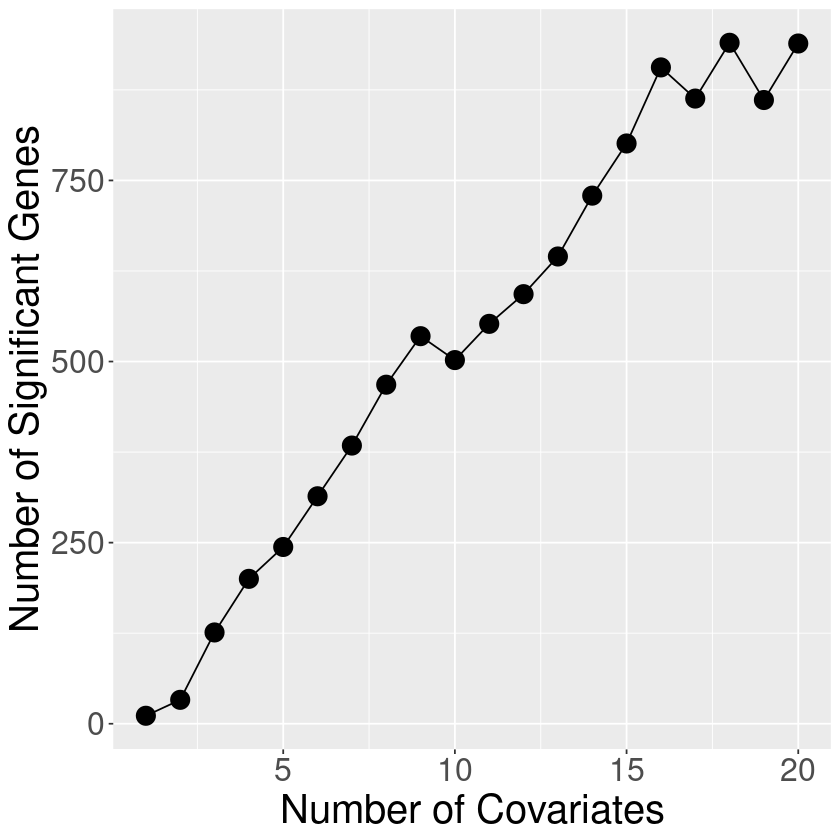

In [ ]:
colnames(deg_counts) = c("formula", "sig_genes")
#plot the number of significant genes vs the number of covariates
ggplot(deg_counts, aes(x=formula, y=sig_genes)) +
    geom_point(size=5) +
    geom_line() +
    xlab("Number of Covariates") +
    ylab("Number of Significant Genes") +
    theme(text = element_text(size = 24))

In [12]:
#use 18 covariates
design_formula = formula(formula_list[[18]])
design_formula

~sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + 
    W_10 + W_11 + W_12 + W_13 + W_14 + +W_15 + W_16 + W_17 + 
    W_18 + recur

In [13]:
dds = DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]
#run DESeq
dds <- DESeq(dds)
res <- results(dds)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



keep
FALSE  TRUE 
28254 29965 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

In [14]:
library('pheatmap')
library('genefilter')
#use RemoveBatchEffect to adjust for the identified covariates
#first create variables for each of the RUV factors
ruv1 = pdat$W_1
ruv2 = pdat$W_2
ruv3 = pdat$W_3
ruv4 = pdat$W_4
ruv5 = pdat$W_5
ruv6 = pdat$W_6
ruv7 = pdat$W_7
ruv8 = pdat$W_8
ruv9 = pdat$W_9
ruv10 = pdat$W_10
ruv11 = pdat$W_11
ruv12 = pdat$W_12
ruv13 = pdat$W_13
ruv14 = pdat$W_14
ruv15 = pdat$W_15
ruv16 = pdat$W_16
ruv17 = pdat$W_17
ruv18 = pdat$W_18

#run RemoveBatchEffect using the RUV factors and sex
vsd = vst(dds)
mat= assay(vsd)
assay(vsd) <- removeBatchEffect(assay(vsd), batch=sex, covariates=cbind(ruv1, ruv2, ruv3, ruv4, ruv5, ruv6, ruv7, ruv8, ruv9, ruv10, ruv11, ruv12, ruv13, ruv14, ruv15, ruv16, ruv17, ruv18))


Attaching package: ‘genefilter’


The following object is masked _by_ ‘.GlobalEnv’:

    varFilter


The following object is masked from ‘package:readr’:

    spec


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars




In [16]:
#plot a PCA of the adjusted data
pcaData <- plotPCA(vsd, intgroup=c("recur"), ntop = 500, returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

#save the plot
png("results/i/pca_ruvg_corrected.png", width=1024, height=1024)
ggplot(pcaData, aes(PC1, PC2, color=inflammation_status, shape=recur)) +
    geom_point(size=5) +
    #geom_text(aes(label=sample),hjust=0, vjust=0) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed() +
    
    theme(text = element_text(size = 24))
dev.off()

png 
  2

In [20]:
resOrdered <- res[order(res$padj),]
resOrdered$gene <- rownames(resOrdered)
resOrdered = resOrdered[,c(7, 1, 2, 3, 4, 5, 6)]
head(resOrdered)

log2 fold change (MLE): recur Recurrent vs Non.recurrent 
Wald test p-value: recur Recurrent vs Non.recurrent 
DataFrame with 6 rows and 7 columns
                                 gene  baseMean log2FoldChange     lfcSE
                          <character> <numeric>      <numeric> <numeric>
ENSG00000100368.15 ENSG00000100368.15  1408.336       0.539294 0.0768059
ENSG00000137462.9   ENSG00000137462.9  1049.409       0.588285 0.0868936
ENSG00000249437.8   ENSG00000249437.8  3875.876       0.353731 0.0533505
ENSG00000185215.11 ENSG00000185215.11  4540.630       0.639195 0.0977397
ENSG00000148926.10 ENSG00000148926.10   559.951       0.758926 0.1183117
ENSG00000162551.14 ENSG00000162551.14   190.099       0.939503 0.1523298
                        stat      pvalue        padj
                   <numeric>   <numeric>   <numeric>
ENSG00000100368.15   7.02152 2.19471e-12 5.68387e-08
ENSG00000137462.9    6.77018 1.28627e-11 1.66558e-07
ENSG00000249437.8    6.63033 3.34947e-11 2.89149e-07
ENSG

In [21]:
#make a list of the top 15 genes
top15 <- resOrdered[1:15,]
recur <- data.frame(recur=coldata$recur)
rownames(recur) <- colnames(mat)
mat15 <- mat[top15$gene,]
#center the data
mat15 <- mat15 - rowMeans(mat15)

In [22]:
#rename the rownames of mat with gene symbols
library("AnnotationDbi")
library("org.Hs.eg.db")

#remove the ENSEMBL version number
rownames(mat15) <- gsub("\\..*", "", rownames(mat15))
rownames(mat15) <- mapIds(org.Hs.eg.db, keys=rownames(mat15), column="SYMBOL", keytype="ENSEMBL", multiVals="first")
head(mat15)

'select()' returned 1:1 mapping between keys and columns



,PB12_770_A9,PB138_A3,PB140_ILEUM,PB146_A1,PB17_236_122_A1,PB17_236_177_A1,PB17_236_292_B1,PB17_236_387_A2,PB17_236_398_A3,PB17_236_520_A4,⋯,PB600444_A1,PB601102_A2,PB601990_A4,PB602717_A1,PB603387_A1,PB603967_A1,PB604520_A1,PB605312_A1,PB75_A2,PBCHAMP7_A2
CSF2RB,0.52512344,2.8377624,-0.6021220,-0.1770484,-0.25796557,-0.06425362,0.2868785,-0.14921148,0.2845260,-0.08435063,⋯,-0.4064393,-0.5568335,-1.3378116,-1.16610877,-0.67243669,0.35995732,-0.83342252,0.40257766,-0.4665220,0.71925940
TLR2,0.89179597,2.2636921,-1.0031877,1.0939214,-0.55847127,-0.45627120,0.5294881,0.11124168,0.1302254,0.11723288,⋯,0.1591417,0.7432911,-0.8464827,-1.60960695,-0.02181970,-0.62367929,0.44506311,-0.37800864,-0.2652700,0.74323054
NAIP,-0.02336788,0.6527014,-0.2458138,0.6773074,0.35933408,-0.26220355,0.1700708,-0.03627255,-0.2029344,0.10937801,⋯,0.2534548,0.3474533,-0.6411854,-0.01508148,0.31191087,-0.41542597,-0.03802279,-0.08339674,0.3257464,0.06336752
TNFAIP2,0.55724426,1.8458881,-0.7173009,1.3904475,0.05184658,-0.53357675,0.2616403,-0.56162364,0.2242787,0.17617249,⋯,0.1048737,0.2863901,-0.7485523,-0.76144035,-0.33943981,-0.01836612,0.03121163,-0.44461538,-0.4992836,0.05442324
ADM,1.13481914,1.7517084,-1.1143721,1.5138080,-0.21274459,-0.36875478,0.9361534,0.07809647,1.2863198,0.28126444,⋯,-0.2434752,0.3774139,-1.0619564,-1.13557939,-0.06722303,-0.65886378,0.22840164,-1.59898471,-1.0683988,0.79392085
ALPL,1.80656149,2.0649235,-0.4402806,0.8126067,-0.52974084,-0.59631612,0.7498372,0.33195363,0.1525135,-0.29982614,⋯,-1.0131805,0.8683495,-1.0037457,-0.99147772,-1.05779024,-0.58845978,-0.48711737,-0.29368516,-0.5780172,1.21870844


In [23]:
#sort each dataframe by recurrence
#first sort the annotation data by recurrence while keeping it as a dataframe
recur <- recur[order(recur$recur), , drop=FALSE]
#then sort the matrix by the order of the annotation data by getting the rownames of the annotation data and reordering the columns of the matrix
col_order = rownames(recur)
mat15 <- mat15[,col_order]

In [24]:
#remove the sample names from the heatmap
pheatmap(mat15, annotation_col=recur, cluster_cols=F, show_colnames=F, filename='../../results/recur/i/ruvg_runs/heatmap.png', height=10, width=10)

In [60]:
#adjust for sex and RUV factors
design <- as.formula(~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + recur)
#create the dds object
dds = DESeqDataSetFromMatrix(countData = cts, colData = pdat, design = design)

#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]

#run DESeq
dds <- DESeq(dds)
res <- results(dds)


converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



keep
FALSE  TRUE 
30087 31027 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 


FALSE  TRUE 
17667  7946 

In [61]:
table(res$padj < 0.05)



FALSE  TRUE 
25006   607 

In [63]:
resOrdered <- res[order(res$padj),]
head(resOrdered)

log2 fold change (MLE): recur Recurrent vs Non.recurrent 
Wald test p-value: recur Recurrent vs Non.recurrent 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000075618.18   476.349       0.572330 0.0916091   6.24753 4.17003e-10
ENSG00000185215.11  4541.105       0.686794 0.1109233   6.19161 5.95514e-10
ENSG00000160255.18  1823.288       0.534797 0.0920382   5.81060 6.22486e-09
ENSG00000090402.8  19287.383      -0.723901 0.1312680  -5.51468 3.49421e-08
ENSG00000100368.15  1408.487       0.615353 0.1188780   5.17634 2.26282e-07
ENSG00000149781.13   739.985       0.358620 0.0692847   5.17603 2.26656e-07
                          padj
                     <numeric>
ENSG00000075618.18 7.62644e-06
ENSG00000185215.11 7.62644e-06
ENSG00000160255.18 5.31458e-05
ENSG00000090402.8  2.23743e-04
ENSG00000100368.15 8.29333e-04
ENSG00000149781.13 8.29333e-

In [64]:
#save the results to csv
write.csv(resOrdered, file="../../results/recur/i/ruvg_runs/res_ruvg9_5.csv")

In [3]:


# Calculate the average gene expression of each genes and take the top 5000 highest expressed
nc <- as.data.frame(assay(vsd))
nc$avg_exp <- rowSums(nc,na.rm=TRUE) / ncol(nc) # x should be your normalized matrix
nc <- arrange(nc, -avg_exp)%>%dplyr::select(-avg_exp)
nc <- nc[1:5000,]

# Calculate the variance of each genes, and choose the lowest 1000 genes as the negative control gene
nc$row_stv <- rowSds(as.matrix(nc))/(rowSums(nc,na.rm=TRUE) / ncol(nc))
nc <- arrange(nc, row_stv) %>% dplyr::select(-row_stv)
nc <- nc[1:1000,]
##The newSeqExpressionSet is given the raw count matrix, phenotypic data, and then the names of the samples 
# Create a new Expression Set and perform an upper quartile normalization
nc <- round(nc*1000)
set <- newSeqExpressionSet(as.matrix(nc),phenoData = data.frame(colData(dds),row.names=colnames(nc)))


##Run RUV
set_ruv<- RUVg(set, rownames(nc), k=10)
# Save the phenotype data
ruv_data <- pData(set_ruv)


In [ ]:

plotRLE(set_ruv, outline=FALSE, ylim=c(-0.1, 0.1), col=as.numeric(as.factor(coldata$disease)))
# dev.off()
#plot RLE plots for ruv factors 1-10
for (x in 1:10) {
    set_ruv <- RUVg(set, rownames(nc), k=x)
    png(sprintf('results/i/rle_%s.png', x))
    plotRLE(set_ruv, outline=FALSE, ylim=c(-0.1, 0.1), col=as.numeric(as.factor(coldata$disease)))
    dev.off()
}


In [23]:
factor_cols = c('sex', 'recur')
for (col in factor_cols) {
  ruv_data[,col] = as.factor(ruv_data[,col])
}
sex = ruv_data$sex
recur = ruv_data$recur
tin = ruv_data$TIN
inflammation_status = ruv_data$inflammation_status

formula_list = list(
~ sex + inflammation_status + W_1 + recur, 
~ sex + inflammation_status + W_1 + W_2 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + recur, 
~ sex + inflammation_status + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + recur)


#create an empty dataframe to store the number of significant genes
deg_counts = data.frame(matrix(ncol=10, nrow=0))
colnames(deg_counts) = c("formula", "sig_genes")

for (x in seq_along(formula_list)) {
    design_formula = formula(formula_list[[x]])
    dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=ruv_data, design = design_formula)
    y <- DGEList(counts=counts(dds1), group=coldata$recur)
    keep <- filterByExpr(y)
    table(keep)
    y <- y[keep,]
    dds1 <- dds1[keep,]
    dds1 <- DESeq(dds1)
    res <- results(dds1)
    res <- res[order(res$padj),]
    #get the number of significant genes
    sig_genes <- res[which(res$padj < 0.05),]
    #save the number of significant genes to the dataframe
    deg_counts = rbind(deg_counts, c(x, nrow(sig_genes)))
}

head(deg_counts, 10)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

,X1L,X12L
,<int>,<int>
1,1,12
2,2,11
3,3,4
4,4,4
5,5,7
6,6,1
7,7,1
8,8,1
9,9,1


In [10]:

#RLE plot
# png("results/i/rle_1.png")
# plotRLE(set_ruv, outline=FALSE, ylim=c(-0.1, 0.1), col=as.numeric(as.factor(coldata$status)))
# dev.off()
ruv_data<-pData(set_ruv)

factor_cols = c('sex', 'inflammation_status', 'recur')
for (col in factor_cols) {
  ruv_data[,col] = as.factor(ruv_data[,col])
}
sex = ruv_data$sex
tissue = ruv_data$tissue
inflammation_status = ruv_data$inflammation_status
recur = ruv_data$recur
tin = ruv_data$TIN

w_1 = ruv_data$W_1

dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=ruv_data, design = ~sex + inflammation_status + W_1 + recur)
vsd = vst(dds1)
mat= assay(vsd)
assay(vsd) <- removeBatchEffect(assay(vsd), batch=sex, batch2=inflammation_status, covariates=cbind(w_1))

#save the PCA, accounting for sex, tin score, and the RUV factor (W_1)
pcaData <- plotPCA(vsd, intgroup=c("recur"), ntop = 500, returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

png("results/i/pca_w1_infl_corrected.png", width=1024, height=512)
ggplot(pcaData, aes(PC1, PC2, color=recur)) +
    geom_point(size=5) +
    # geom_text(aes(label=sample),hjust=0, vjust=0) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed() +
    # scale_color_manual(values = c("Non-recurrent" = "#0066cc", "Recurrent" = "#990000")) + 
    theme(text = element_text(size = 24))
dev.off()

#write out the matrix to csv
write.csv(mat, file="results/i/data_ruv1.csv")

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



png 
  2

In [11]:
png("results/i/pca_w1_source_corrected.png", width=1024, height=512)
ggplot(pcaData, aes(PC1, PC2, color=source)) +
    geom_point(size=5) +
    # geom_text(aes(label=sample),hjust=0, vjust=0) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed() +
    # scale_color_manual(values = c("Non-recurrent" = "#0066cc", "Recurrent" = "#990000")) + 
    theme(text = element_text(size = 24))
dev.off()

png 
  2

In [25]:
#now the DESeq analysis
dds1 <- DESeqDataSetFromMatrix(countData=cts,colData=ruv_data,design = ~sex + inflammation_status + W_1 + recur)
#filter out lowly expressed genes
y <- DGEList(counts=counts(dds1), group=coldata$recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds1 <- dds1[keep,]
#run DESeq
dds1 <- DESeq(dds1)
#get the results, with nonIBD as the reference
res <- results(dds1, contrast=c('recur', 'Recurrent', 'Non-recurrent'))
#order the results by adjusted p-value
resOrdered <- res[order(res$padj),]
#create a column named gene which is the gene name
resOrdered$gene = rownames(resOrdered)
#set gene as the first column by making the last column the first column
resOrdered = resOrdered[,c(7, 1, 2, 3, 4, 5, 6)]
head(resOrdered)

write.csv(resOrdered, file="results/i/res_ruv1_infl.csv")

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



keep
FALSE  TRUE 
30087 31027 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

log2 fold change (MLE): recur Recurrent vs Non-recurrent 
Wald test p-value: recur Recurrent vs Non.recurrent 
DataFrame with 6 rows and 7 columns
                                 gene  baseMean log2FoldChange     lfcSE
                          <character> <numeric>      <numeric> <numeric>
ENSG00000198019.13 ENSG00000198019.13  129.4259       1.341187  0.258688
ENSG00000255398.3   ENSG00000255398.3  312.7256       2.940584  0.559086
ENSG00000276085.1   ENSG00000276085.1   78.5554       1.858028  0.355389
ENSG00000185215.11 ENSG00000185215.11 4541.1053       0.682521  0.133846
ENSG00000091106.19 ENSG00000091106.19  127.1549       0.899212  0.184106
ENSG00000115956.10 ENSG00000115956.10 1560.4577       1.306197  0.272382
                        stat      pvalue       padj
                   <numeric>   <numeric>  <numeric>
ENSG00000198019.13   5.18458 2.16507e-07 0.00197866
ENSG00000255398.3    5.25963 1.44349e-07 0.00197866
ENSG00000276085.1    5.22816 1.71205e-07 0.00197866
ENSG00000